<a href="https://colab.research.google.com/github/realmistic/PythonInvest-basic-fin-analysis/blob/master/Part_8_Practical_Portfolio_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **Portfolio Optimisation**
* **What?** Identify optimal split between known stocks for a given investment size
* **Why?** Smart portfolio management can reduce the volatility of a portfolio, and increase returns per unit of risk
* **Tech skills with Python** Learn Ordered Dictionaries in Python, do the recursive brute force algorithm for all portfolios generation.
* **How?**
  1. Define the initial set of stocks and download data from yfinance
  2. What is a Portfolio? From individual stock to a set of stocks
  3. Build the correlation matrix
  4. Use the library to give a quick answer and to compare
  5.  Manual check: build all possible combinations to buy : with limitations of not buying fractional shares.
  6. Manual check: do the simulations for a given a portfolio. 3d-investments ==> distribution of returns, sharpe ratio. Draw the plots of Efficient frontier


In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.5 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=c2377a86b8f965fe41c78dcdc566e37714f30e5d6a3ab7683ea6a9a7c846440d
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
# IMPORTANT: please do these commands and restart the runtime if you run the notebook for the first time
  # DO NOT run this cell during the next runs for the same session

# Reason: some of the Plotly Express graphs are not working by default
# Details: https://stackoverflow.com/questions/61456267/treemap-got-an-unexpected-keyword-argument-path-in-plotly-express

# -y == silent uninstall  
!pip uninstall -y plotly
 
!pip install --upgrade plotly

Found existing installation: plotly 4.4.1
Uninstalling plotly-4.4.1:
  Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 20.6 MB 1.2 MB/s 


In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
INVESTMENT = 2000 
# TICKERS = ['GE', 'HD', 'DHR', 'PDD', 'AVGO','BMY','PG']
# TICKERS = ['GE', 'HD', 'DHR','AMZN','PDD']
# TICKERS = ['C', 'JPM', 'HON']
# TICKERS = ['BABA', 'JPM', 'MS']
# TICKERS = ['BABA', 'HSBC', 'SBUX']
# TICKERS = ['BABA', 'SNY', 'SAP', 'NVO']
# TICKERS = ['ACN', 'HSBC',  'MMM','UL']
# TICKERS = ['BABA', 'SNY', 'SAP', 'NVO']

# TICKERS = ['AMC', 'AAPL', 'MSFT', 'DOCU', 'MRNA']
# TICKERS = ['BUD', 'HDB', 'IBM', 'BA', 'CVS']
# TICKERS = ['BUD', 'BABA', 'HSBC', 'CVS', 'C']
# TICKERS = ['BUD', 'BABA', 'PDD', 'BA','PTR']

# TICKERS = ['BUD', 'BABA', 'PDD', 'XOM','PTR']
# TICKERS = ['EL', 'CRM', 'XOM','TM', 'CAT']

# TICKERS = ['BUD', 'BABA', 'PDD', 'PTR','EL', 'CRM', 'XOM','TM', 'CAT']

# TICKERS = ['TOT', 'SHOP', 'PM', 'BA','BABA', 'UNP', 'CHTR','BX']

# TICKERS =['PTR','BA','CHTR','SHOP','TMO','PDD','TM','CAT']
# TICKERS =['PTR','BUD', 'TMO', 'BA','CHTR']

TICKERS =['PTR','BUD', 'XOM', 'BA','CHTR', 'SHOP', 'NVDA', 'NKE']

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)


# 0) Get the yfinance data

In [ ]:
stocks_prices = pd.DataFrame({'A' : []})
stocks_info = pd.DataFrame({'A' : []})

for i,ticker in enumerate(TICKERS):
  print(i,ticker)
  yticker = yf.Ticker(ticker)
  
  # Get max history of prices
  historyPrices = yticker.history(period='max')
  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date
  
  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)

  # future growth 3 days  
  historyPrices['future_growth_3d'] = historyPrices['Close'].shift(-3) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  if stocks_prices.empty:
    stocks_prices = historyPrices
  else: 
    stocks_prices = pd.concat([stocks_prices,historyPrices], ignore_index=True)


0 PTR
1 BUD
2 XOM
3 BA
4 CHTR
5 SHOP
6 NVDA
7 NKE


In [ ]:
# Check one day
filter_last_date = stocks_prices.Date==stocks_prices.Date.max()
print(stocks_prices.Date.max())

2021-08-04


In [ ]:
stocks_prices[filter_last_date]

Open         High          Low        Close      Volume  \
5365     42.200001    42.200001    41.430000    41.580002    243200.0   
8410     62.189999    62.380001    61.299999    61.349998   2036800.0   
23409    57.189999    57.880001    56.810001    56.840000  20854300.0   
38410   226.419998   232.350006   225.330002   226.630005   9741000.0   
41320   770.219971   771.869995   763.090027   770.000000   1069300.0   
42884  1524.079956  1558.250000  1517.010010  1555.520020    668100.0   
48556   199.899994   203.179993   198.279999   202.740005  23098300.0   
58810   171.360001   172.339996   170.960007   171.910004   4645400.0   

       Dividends  Stock Splits Ticker  Year  Month  Weekday        Date  \
5365         0.0           0.0    PTR  2021      8        2  2021-08-04   
8410         0.0           0.0    BUD  2021      8        2  2021-08-04   
23409        0.0           0.0    XOM  2021      8        2  2021-08-04   
38410        0.0           0.0     BA  2021      8        2  2021-08-04   
41320        0.0           0.0   CHTR  2021      8        2  2021-08-04   
42884        0.0           0.0   SHOP  2021      8        2  2021-08-04   
48556        0.0           0.0   NVDA  2021      8        2  2021-08-04   
58810        0.0           0.0    NKE  2021      8        2  2021-08-04   

       growth_1d  growth_3d  growth_7d  growth_30d  growth_90d  growth_365d  \
5365    0.978583   0.993786   0.988823    0.882054    1.176514     1.112159   
8410    0.981443   0.974119   0.889002    0.807768    0.977172     0.900504   
23409   0.976632   0.987320   0.971956    0.891049    0.999273     1.107785   
38410   0.989262   1.000662   1.003454    0.929650    0.925512     0.712897   
41320   0.999974   1.034877   1.055286    1.089124    1.218837     1.456402   
42884   1.021648   1.037062   0.983088    1.031211    1.460294     3.168323   
48556   1.023164   1.039746   1.050793    1.073451    1.579426     2.974110   
58810   1.003971   1.026267   1.041311    1.297630    1.295262     1.816828   

       future_growth_3d  volatility  
5365                NaN   48.509232  
8410                NaN   58.684716  
23409               NaN   43.382328  
38410               NaN  156.417466  
41320               NaN  274.698477  
42884               NaN  762.711453  
48556               NaN   96.390253  
58810               NaN  137.014013

In [ ]:
stocks_prices[stocks_prices.Ticker=='AMZN'].tail()

Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Dividends, Stock Splits, Ticker, Year, Month, Weekday, Date, growth_1d, growth_3d, growth_7d, growth_30d, growth_90d, growth_365d, future_growth_3d, volatility]
Index: []

# 1) Correlations Matrix

Also check this template: https://medium.com/the-innovation/basic-interactive-stock-analysis-template-286f06973a86

In [ ]:
# https://medium.com/analytics-vidhya/how-to-create-a-stock-correlation-matrix-in-python-4f32f8cb5b50
df_pivot = stocks_prices.pivot('Date','Ticker','Close').reset_index()
df_pivot.tail(1)

Ticker        Date          BA        BUD   CHTR         NKE        NVDA  \
15001   2021-08-04  226.630005  61.349998  770.0  171.910004  202.740005   

Ticker        PTR        SHOP    XOM  
15001   41.580002  1555.52002  56.84

In [ ]:
df_pivot.corr()

Ticker        BA       BUD      CHTR       NKE      NVDA       PTR      SHOP  \
Ticker                                                                         
BA      1.000000  0.434444  0.689035  0.869344  0.660043  0.084514  0.050669   
BUD     0.434444  1.000000  0.214633  0.265831  0.024439 -0.180022 -0.730986   
CHTR    0.689035  0.214633  1.000000  0.963651  0.920692 -0.852483  0.931354   
NKE     0.869344  0.265831  0.963651  1.000000  0.896679  0.032580  0.946700   
NVDA    0.660043  0.024439  0.920692  0.896679  1.000000 -0.151125  0.945112   
PTR     0.084514 -0.180022 -0.852483  0.032580 -0.151125  1.000000 -0.738964   
SHOP    0.050669 -0.730986  0.931354  0.946700  0.945112 -0.738964  1.000000   
XOM     0.768762  0.769451 -0.104924  0.678223  0.247557  0.744154 -0.655432   

Ticker       XOM  
Ticker            
BA      0.768762  
BUD     0.769451  
CHTR   -0.104924  
NKE     0.678223  
NVDA    0.247557  
PTR     0.744154  
SHOP   -0.655432  
XOM     1.000000

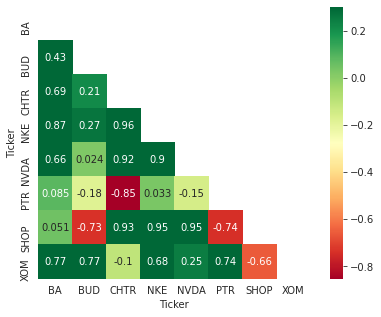

In [ ]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html

corr = df_pivot.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, cmap='RdYlGn')


In [ ]:
df_last_day_prices = stocks_prices[filter_last_date][['Ticker','Close']]
df_last_day_prices

Ticker        Close
5365     PTR    41.580002
8410     BUD    61.349998
23409    XOM    56.840000
38410     BA   226.630005
41320   CHTR   770.000000
42884   SHOP  1555.520020
48556   NVDA   202.740005
58810    NKE   171.910004

In [ ]:
df_last_day_prices.set_index('Ticker',inplace=True)

In [ ]:
df_last_day_prices.sort_values(by='Close', ascending=False)

Close
Ticker             
SHOP    1555.520020
CHTR     770.000000
BA       226.630005
NVDA     202.740005
NKE      171.910004
BUD       61.349998
XOM       56.840000
PTR       41.580002

# 2) PyPortfolioOpt - find weights using the library

RESULT: discrete optimal portfolio

In [ ]:
# https://github.com/robertmartin8/PyPortfolioOpt
!pip install PyPortfolioOpt

import pypfopt
print(f'\n Library version: {pypfopt.__version__}')

     |████████████████████████████████| 60 kB 3.3 MB/s 
     |████████████████████████████████| 2.7 MB 10.3 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31

 Library version: 1.4.2


In [ ]:
# https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb

from pypfopt import risk_models
from pypfopt import plotting

In [ ]:
sample_cov = risk_models.sample_cov(df_pivot.set_index('Date'), frequency=252)
sample_cov

Ticker        BA       BUD      CHTR       NKE      NVDA       PTR      SHOP  \
Ticker                                                                         
BA      0.114177  0.045342  0.029827  0.031452  0.053414  0.044333  0.054496   
BUD     0.045342  0.070389  0.018602  0.024929  0.032286  0.033967  0.027912   
CHTR    0.029827  0.018602  0.076680  0.022631  0.035118  0.022489  0.040281   
NKE     0.031452  0.024929  0.022631  0.117147  0.048116  0.034529  0.044354   
NVDA    0.053414  0.032286  0.035118  0.048116  0.369043  0.060828  0.103909   
PTR     0.044333  0.033967  0.022489  0.034529  0.060828  0.129240  0.034519   
SHOP    0.054496  0.027912  0.040281  0.044354  0.103909  0.034519  0.323220   
XOM     0.027473  0.031386  0.019367  0.022976  0.040037  0.048562  0.022115   

Ticker       XOM  
Ticker            
BA      0.027473  
BUD     0.031386  
CHTR    0.019367  
NKE     0.022976  
NVDA    0.040037  
PTR     0.048562  
SHOP    0.022115  
XOM     0.051429

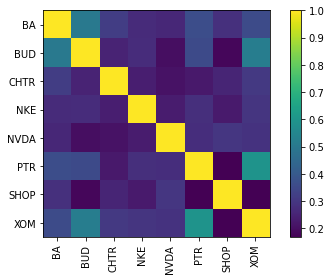

In [ ]:
plotting.plot_covariance(sample_cov, plot_correlation=True);

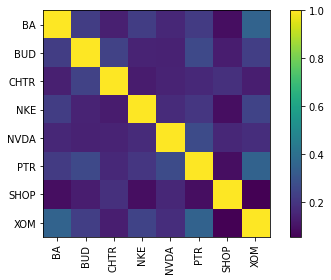

In [ ]:
S = risk_models.CovarianceShrinkage(df_pivot.set_index('Date')).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);

In [ ]:
S

Ticker        BA       BUD      CHTR       NKE      NVDA       PTR      SHOP  \
Ticker                                                                         
BA      0.113817  0.009140  0.005761  0.021351  0.020046  0.015747  0.005639   
BUD     0.009140  0.014605  0.003602  0.005031  0.006527  0.006840  0.002864   
CHTR    0.005761  0.003602  0.015269  0.004387  0.006834  0.004323  0.004246   
NKE     0.021351  0.005031  0.004387  0.080009  0.018101  0.012278  0.004617   
NVDA    0.020046  0.006527  0.006834  0.018101  0.139166  0.021654  0.010938   
PTR     0.015747  0.006840  0.004323  0.012278  0.021654  0.046348  0.003520   
SHOP    0.005639  0.002864  0.004246  0.004617  0.010938  0.003520  0.034134   
XOM     0.027286  0.006317  0.003718  0.015600  0.014999  0.017240  0.002246   

Ticker       XOM  
Ticker            
BA      0.027286  
BUD     0.006317  
CHTR    0.003718  
NKE     0.015600  
NVDA    0.014999  
PTR     0.017240  
SHOP    0.002246  
XOM     0.051496

Expected returns from each stock: Ticker
BA      0.214378
BUD     0.140177
CHTR    0.128496
NKE     0.198096
NVDA    0.395522
PTR     0.220099
SHOP    0.292879
XOM     0.129524
Name: mkt, dtype: float64 

Portfolio weights for min volatility optimisation (lowest level of risk): {
    "BA": 0.0,
    "BUD": 0.37214,
    "CHTR": 0.35668,
    "NKE": 0.03077,
    "NVDA": 0.0,
    "PTR": 0.04423,
    "SHOP": 0.14425,
    "XOM": 0.05194
} 

Expected annual return: 16.3%
Annual volatility: 8.9%
Sharpe Ratio: 1.69
Portfolio performance: (0.16280187012757663, 0.08898359416885636, 1.6902202201697114) 

Portfolio weights for max Sharpe optimisation (highest return-per-risk): {
    "BA": 0.01318,
    "BUD": 0.23948,
    "CHTR": 0.15528,
    "NKE": 0.0412,
    "NVDA": 0.07844,
    "PTR": 0.11107,
    "SHOP": 0.36135,
    "XOM": 0.0
} 

Expected annual return: 22.6%
Annual volatility: 10.7%
Sharpe Ratio: 1.92
Portfolio performance: (0.2258118694269962, 0.10704509290593174, 1.9226651483021082) 



/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:412: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  UserWarning,


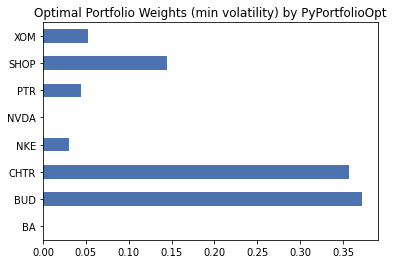

In [ ]:
from pypfopt import expected_returns
from pypfopt import EfficientFrontier

# json: for pretty print of a dictionary: https://stackoverflow.com/questions/44689546/how-to-print-out-a-dictionary-nicely-in-python/44689627
import json

mu = expected_returns.capm_return(df_pivot.set_index('Date'))
# Other options for the returns values: expected_returns.ema_historical_return(df_pivot.set_index('Date'))
# Other options for the returns values: expected_returns.mean_historical_return(df_pivot.set_index('Date'))
print(f'Expected returns from each stock: {mu} \n')

S = risk_models.CovarianceShrinkage(df_pivot.set_index('Date')).ledoit_wolf()

# Weights between 0 and 1 - we don't allow shorting
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef.min_volatility()
weights_min_volatility = ef.clean_weights()

print(f'Portfolio weights for min volatility optimisation (lowest level of risk): {json.dumps(weights_min_volatility, indent=4, sort_keys=True)} \n')
print(f'Portfolio performance: {ef.portfolio_performance(verbose=True, risk_free_rate=0.0124)} \n')
# Risk-free rate : 10Y TBonds rate on 21-Jul-2021 https://www.cnbc.com/quotes/US10Y

pd.Series(weights_min_volatility).plot.barh(title = 'Optimal Portfolio Weights (min volatility) by PyPortfolioOpt');

ef.max_sharpe()
weights_max_sharpe = ef.clean_weights()


print(f'Portfolio weights for max Sharpe optimisation (highest return-per-risk): {json.dumps(weights_max_sharpe, indent=4, sort_keys=True)} \n')
print(f'Portfolio performance: {ef.portfolio_performance(verbose=True, risk_free_rate=0.0124)} \n')



In [ ]:
expected_returns.np

<module 'numpy' from '/usr/local/lib/python3.7/dist-packages/numpy/__init__.py'>

In [ ]:
# last day prices
df_pivot.set_index('Date').iloc[-1]

Ticker
BA       226.630005
BUD       61.349998
CHTR     770.000000
NKE      171.910004
NVDA     202.740005
PTR       41.580002
SHOP    1555.520020
XOM       56.840000
Name: 2021-08-04, dtype: float64

In [ ]:
from pypfopt import DiscreteAllocation

latest_prices = df_pivot.set_index('Date').iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights_max_sharpe, latest_prices, total_portfolio_value = INVESTMENT, short_ratio=0.0)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

Discrete allocation performed with $115.07 leftover


{'BUD': 8, 'CHTR': 1, 'NKE': 1, 'NVDA': 1, 'PTR': 6}

In [ ]:
for key in alloc.keys():
  print(f' stock: {key}, value = {alloc[key]*latest_prices[key]/INVESTMENT}')

 stock: BUD, value = 0.24539999389648437
 stock: CHTR, value = 0.385
 stock: NKE, value = 0.08595500183105469
 stock: NVDA, value = 0.10137000274658203
 stock: PTR, value = 0.12474000549316407


# 3) Manual optimisation: OrderedDict in Python and brute force to generate all possible portfolios 
(discrete values for stocks, no short selling)

## 3.1) Working with Ordered Dictionary in Python

In [ ]:
from collections import OrderedDict

In [ ]:
dict_stocks_prices =  OrderedDict(df_last_day_prices.sort_values(by='Close', ascending=False)['Close'].to_dict())
dict_stocks_prices

OrderedDict([('SHOP', 1555.52001953125),
             ('CHTR', 770.0),
             ('BA', 226.6300048828125),
             ('NVDA', 202.74000549316406),
             ('NKE', 171.91000366210938),
             ('BUD', 61.349998474121094),
             ('XOM', 56.84000015258789),
             ('PTR', 41.58000183105469)])

In [ ]:
for key in dict_stocks_prices.keys():
  print(f' STOCK = {key}, LAST PRICE = {np.round(dict_stocks_prices[key])}, MAX_COUNT = {np.trunc(INVESTMENT/dict_stocks_prices[key])}')

 STOCK = SHOP, LAST PRICE = 1556.0, MAX_COUNT = 1.0
 STOCK = CHTR, LAST PRICE = 770.0, MAX_COUNT = 2.0
 STOCK = BA, LAST PRICE = 227.0, MAX_COUNT = 8.0
 STOCK = NVDA, LAST PRICE = 203.0, MAX_COUNT = 9.0
 STOCK = NKE, LAST PRICE = 172.0, MAX_COUNT = 11.0
 STOCK = BUD, LAST PRICE = 61.0, MAX_COUNT = 32.0
 STOCK = XOM, LAST PRICE = 57.0, MAX_COUNT = 35.0
 STOCK = PTR, LAST PRICE = 42.0, MAX_COUNT = 48.0


In [ ]:
copy_dict = dict_stocks_prices.copy() 
copy_dict

OrderedDict([('SHOP', 1555.52001953125),
             ('CHTR', 770.0),
             ('BA', 226.6300048828125),
             ('NVDA', 202.74000549316406),
             ('NKE', 171.91000366210938),
             ('BUD', 61.349998474121094),
             ('XOM', 56.84000015258789),
             ('PTR', 41.58000183105469)])

In [ ]:
# https://stackoverflow.com/questions/21062781/shortest-way-to-get-first-item-of-ordereddict-in-python-3/27666721
def first(s):
    '''Return the first element from an ordered collection
       or an arbitrary element from an unordered collection.
       Raise StopIteration if the collection is empty.
    '''
    return next(iter(s))

In [ ]:
# Get the first element from the OrderedDict, the dictionary is reduced

# https://stackoverflow.com/questions/23177439/python-checking-if-a-dictionary-is-empty-doesnt-seem-to-work
item = first(copy_dict)
elem = copy_dict.pop(item)

In [ ]:
print(item, elem)
print(copy_dict)
print(dict_stocks_prices)

SHOP 1555.52001953125
OrderedDict([('CHTR', 770.0), ('BA', 226.6300048828125), ('NVDA', 202.74000549316406), ('NKE', 171.91000366210938), ('BUD', 61.349998474121094), ('XOM', 56.84000015258789), ('PTR', 41.58000183105469)])
OrderedDict([('SHOP', 1555.52001953125), ('CHTR', 770.0), ('BA', 226.6300048828125), ('NVDA', 202.74000549316406), ('NKE', 171.91000366210938), ('BUD', 61.349998474121094), ('XOM', 56.84000015258789), ('PTR', 41.58000183105469)])


## 3.2) All portfolios consisting from one stock

In [ ]:
# Get all options for one-stock investment portfolio (not nessesary spending full sum of money)
def invest_one_stock(investment, dict_stocks_prices):
  selected_stock = first(dict_stocks_prices)
  price = dict_stocks_prices.pop(selected_stock)
  max_count = np.trunc(investment / price).astype(int)
  print(f'STOCK = {selected_stock}, PRICE = {price}, MAX_TO_BUY = {max_count}')
  
  all_options = []
  print(type(max_count))
  print(list(range(0, max_count+1)) )
  
  for count in range(0, int(max_count)+1):
    result = dict({selected_stock:count})
    print(f'portfolio = {result}, remaining_to_invest = {investment-count*price}')
    all_options.append(result)
  return all_options  

In [ ]:
portfolios_one_stock = invest_one_stock(INVESTMENT, dict_stocks_prices.copy())

STOCK = SHOP, PRICE = 1555.52001953125, MAX_TO_BUY = 1
<class 'numpy.int64'>
[0, 1]
portfolio = {'SHOP': 0}, remaining_to_invest = 2000.0
portfolio = {'SHOP': 1}, remaining_to_invest = 444.47998046875


In [ ]:
# all options for a partial portfolio investment
portfolios_one_stock

[{'SHOP': 0}, {'SHOP': 1}]

In [ ]:
# update command for a dictionary : add arbitrary ANOTHER_STOCK investment (if we have 2 or more stocks in the portfolio)
portfolios_one_stock[0].update({'ANOTHER_STOCK':3})

In [ ]:
portfolios_one_stock

[{'ANOTHER_STOCK': 3, 'SHOP': 0}, {'SHOP': 1}]

## 3.3) Generate All portfolios for a given set of stocks and the investment : recursive function
all_portfolios[investment, OrderedDict(stocks_options)] = <all_options_with_first_stock + all_portfolios[investment_left, OrderedDict(stocks_options).pop()>

In [ ]:
def generate_all_portfolios(investment, dict_stocks_prices):
  
  # DEBUG: 
  # print(f'This call: invest_all_stocks({investment}, {dict_stocks_prices})')
  
  # if no stocks to invest ==> return zero portfolio
  if not dict_stocks_prices:
    return []

  # we have at least one stock to invest to ==> try to find min and max investment into that stock
  selected_stock = first(dict_stocks_prices)
  price = dict_stocks_prices.pop(selected_stock)
  max_count = np.trunc(investment / price).astype(int)

  # print(f'STOCK = {selected_stock}, PRICE = {price}, MAX_TO_BUY = {max_count}, INVESTMENT = {investment}')
  # print(f'   INPUT DICT LEFT AFTER THIS TRANSACTION = {dict_stocks_prices}')
  
  # if can't buy a current stock ==> try to buy a next one (which is a lower price) 
  if max_count ==0:
    return generate_all_portfolios(investment, dict_stocks_prices.copy())

  # if no other stocks left to buy ==> spend all money on the current stock and return 1 option in array: full stock investment
  if len(dict_stocks_prices.keys())==0:
    return [{selected_stock:max_count}]  
  
  all_options = []
  for count in range(0, max_count+1):
    result = dict({selected_stock:count})
    other_portfolios = generate_all_portfolios(investment - count*price, dict_stocks_prices.copy())
    for option in other_portfolios:
      result.update(option)
      all_options.append(dict(result))

  # DEBUG:
  # print(f'all options={all_options}')    
  return all_options  

In [ ]:
all_portfolios = generate_all_portfolios(INVESTMENT, dict_stocks_prices.copy())

In [ ]:
import random

In [ ]:
for elem in all_portfolios[-1]:
  print(f' elem = {elem}, price = {dict_stocks_prices[elem]}')

 elem = SHOP, price = 1555.52001953125
 elem = BA, price = 226.6300048828125
 elem = NVDA, price = 202.74000549316406
 elem = NKE, price = 171.91000366210938
 elem = BUD, price = 61.349998474121094
 elem = XOM, price = 56.84000015258789
 elem = PTR, price = 41.58000183105469


In [ ]:
print(f'Found combinations of portfolios: {len(all_portfolios)}')
for ii in range(1, 6, 1):
    random_portfolio = random.choice(all_portfolios)
    random_portfolio_price = 0
    for elem in random_portfolio:
      random_portfolio_price += random_portfolio[elem] * dict_stocks_prices[elem]
    print(f'Random portfolio {ii}: {random_portfolio} with total price {np.round(random_portfolio_price,1)}')

Found combinations of portfolios: 22569
Random portfolio 1: {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 13, 'XOM': 16, 'PTR': 7} with total price 1998.0
Random portfolio 2: {'SHOP': 0, 'CHTR': 0, 'BA': 3, 'NVDA': 0, 'NKE': 0, 'BUD': 1, 'XOM': 7, 'PTR': 20} with total price 1970.7
Random portfolio 3: {'SHOP': 0, 'CHTR': 0, 'BA': 4, 'NVDA': 1, 'NKE': 2, 'BUD': 4, 'XOM': 2, 'PTR': 4} with total price 1978.5
Random portfolio 4: {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 1, 'BUD': 5, 'XOM': 5, 'PTR': 29} with total price 1968.7
Random portfolio 5: {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 2, 'NKE': 1, 'BUD': 3, 'XOM': 2, 'PTR': 27} with total price 1997.8


## 3.4) Build performance metrics (risk, return, risk/return, CVAr, Max_drawdown) for a given portfolio

In [ ]:
SELECTED_PORTFOLIO = {'BA': 2, 'BUD': 1, 'NKE': 1, 'PTR': 1, 'SHOP': 0, 'XOM': 1, 'NVDA':2, 'CHTR':1 }
# SELECTED_PORTFOLIO = all_portfolios[-100]
SELECTED_PORTFOLIO

{'BA': 2,
 'BUD': 1,
 'CHTR': 1,
 'NKE': 1,
 'NVDA': 2,
 'PTR': 1,
 'SHOP': 0,
 'XOM': 1}

In [ ]:
stocks_prices["Date"] = pd.to_datetime(stocks_prices.Date)

In [ ]:
one_day = stocks_prices[stocks_prices.Date == '2021-06-08'][['Date','Ticker','Close']].set_index('Date')

In [ ]:
one_day

Ticker        Close
Date                          
2021-06-08    PTR    42.132179
2021-06-08    BUD    78.820000
2021-06-08    XOM    62.130001
2021-06-08     BA   252.759995
2021-06-08   CHTR   677.909973
2021-06-08   SHOP  1230.739990
2021-06-08   NVDA   174.530014
2021-06-08    NKE   133.350006

In [ ]:
# Mapping quantity for a daily investment
# https://stackoverflow.com/questions/29794959/pandas-add-new-column-to-dataframe-from-dictionary
one_day['qty']= one_day.Ticker.map(SELECTED_PORTFOLIO)

In [ ]:
one_day

Ticker        Close  qty
Date                               
2021-06-08    PTR    42.132179    1
2021-06-08    BUD    78.820000    1
2021-06-08    XOM    62.130001    1
2021-06-08     BA   252.759995    2
2021-06-08   CHTR   677.909973    1
2021-06-08   SHOP  1230.739990    0
2021-06-08   NVDA   174.530014    2
2021-06-08    NKE   133.350006    1

In [ ]:
portfolio_value_one_day = np.sum(one_day.Close * one_day.qty)
portfolio_value_one_day

1848.922176361084

In [ ]:
all_days = stocks_prices[['Date','Ticker','Close']].set_index('Date')
all_days['qty'] = all_days.Ticker.map(SELECTED_PORTFOLIO)
all_days['price'] = all_days.qty * all_days.Close

In [ ]:
portfolio_value_daily = all_days[all_days.index>='2018-01-01'].groupby('Date')['price'].sum()
# daily_investment = pd.pivot_table(all_stocks_portfolio, values='Close', index=['Ticker'], columns=['Close'], aggfunc=np.sum)
portfolio_value_daily

Date
2018-01-02    1309.242607
2018-01-03    1323.524174
2018-01-04    1321.767452
2018-01-05    1348.113960
2018-01-08    1359.608292
                 ...     
2021-07-29    1903.219994
2021-07-30    1916.889984
2021-08-02    1926.799992
2021-08-03    1958.929996
2021-08-04    1960.420025
Name: price, Length: 904, dtype: float64

In [ ]:
df_portfolio_value_daily = pd.DataFrame(portfolio_value_daily)

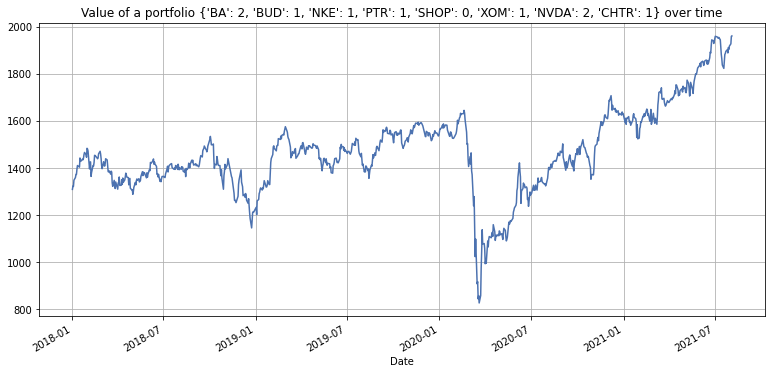

In [ ]:
df_portfolio_value_daily.price.plot.line(title=f"Value of a portfolio {SELECTED_PORTFOLIO} over time", grid = True, figsize=(13,6))

In [ ]:
# Interactive graph - you can zoom in
fig = px.line(df_portfolio_value_daily, x=df_portfolio_value_daily.index, y="price", title=f'Value of a portfolio {SELECTED_PORTFOLIO} over time -- DYNAMIC')
fig.show()


In [ ]:
# Export visualisation outside to enable embedding to the website
  # Check this link for more: https://towardsdatascience.com/how-to-create-a-plotly-visualization-and-embed-it-on-websites-517c1a78568b

# YOU NEED TO CREATE YOUR OWN (FREE ACCOUNT) AND EXPORT THE GRAPH THERE

!pip install chart_studio
import chart_studio

     |████████████████████████████████| 64 kB 1.8 MB/s 


In [ ]:
# username = # <your username>
# api_key =  # <your api key> - go to profile in https://chart-studio.plotly.com/ > settings > regenerate key
# chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [ ]:
# This will create a permanent link for the graph on plotly.com

# import chart_studio.plotly as py

# py.plot(fig, filename = 'part8_fig1_portfolio_value', auto_open=True)

# Output link: https://plotly.com/~realmistic/1/
# You can embed that as iframe to your website (and customise)
# https://plotly.com/chart-studio-help/embed-graphs-in-websites/#step-8-customize-the-iframe

'https://plotly.com/~realmistic/1/'

In [ ]:
# Generate all metrics for the portfolio
df_portfolio_value_daily['return_1d'] = df_portfolio_value_daily.price / df_portfolio_value_daily.price.shift(1)
df_portfolio_value_daily['return_3d'] = df_portfolio_value_daily.price / df_portfolio_value_daily.price.shift(3)

# 30d rolling volatility annualized: https://ycharts.com/glossary/terms/rolling_vol_30
df_portfolio_value_daily['volatility_3d'] =   df_portfolio_value_daily['return_1d'].rolling(30).std() * np.sqrt(3)
# monthly volatility
df_portfolio_value_daily['volatility_30d'] =   df_portfolio_value_daily['return_1d'].rolling(30).std() * np.sqrt(21)
# yearly volatility
df_portfolio_value_daily['volatility_365d'] =   df_portfolio_value_daily['return_1d'].rolling(30).std() * np.sqrt(251)

df_portfolio_value_daily['return_per_volatility_3d'] = (df_portfolio_value_daily['return_3d']-1) / df_portfolio_value_daily['volatility_3d']

In [ ]:
df_portfolio_value_daily.tail()

price  return_1d  return_3d  volatility_3d  volatility_30d  \
Date                                                                           
2021-07-29  1903.219994   0.995997   1.000710       0.016773        0.044377   
2021-07-30  1916.889984   1.007183   1.015184       0.016725        0.044251   
2021-08-02  1926.799992   1.005170   1.008336       0.016509        0.043680   
2021-08-03  1958.929996   1.016675   1.029271       0.016725        0.044251   
2021-08-04  1960.420025   1.000761   1.022709       0.016317        0.043171   

            volatility_365d  return_per_volatility_3d  
Date                                                   
2021-07-29         0.153423                  0.042320  
2021-07-30         0.152986                  0.907820  
2021-08-02         0.151011                  0.504954  
2021-08-03         0.152985                  1.750135  
2021-08-04         0.149253                  1.391701

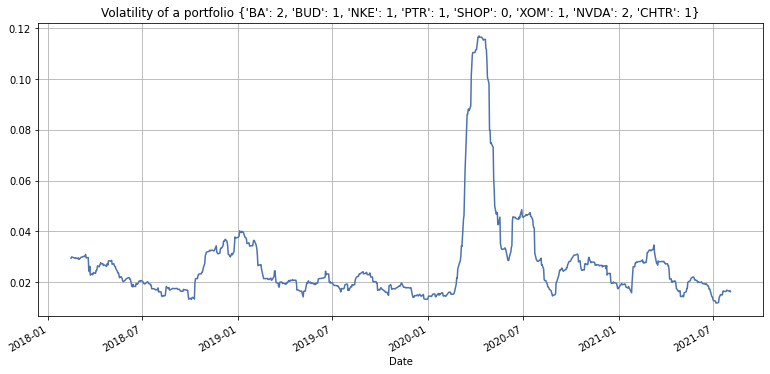

In [ ]:
df_portfolio_value_daily.volatility_3d.plot.line(title= f'Volatility of a portfolio {SELECTED_PORTFOLIO}', grid = True, figsize=(13,6))

In [ ]:
# Create rolling 30 days value to smooth stats for return_per_volatility
df_portfolio_value_daily['return_per_volatility_3d_rolling'] = df_portfolio_value_daily['return_per_volatility_3d'].rolling(30).mean()

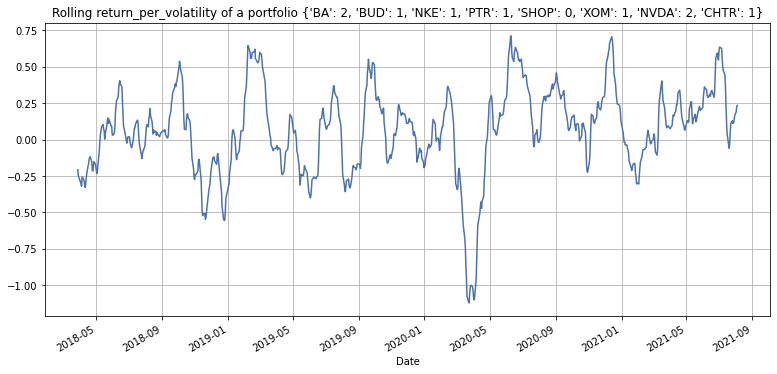

In [ ]:
df_portfolio_value_daily.return_per_volatility_3d_rolling.plot.line(title= f'Rolling return_per_volatility of a portfolio {SELECTED_PORTFOLIO}', grid = True, figsize=(13,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f91f4093dd0>,
      dtype=object)

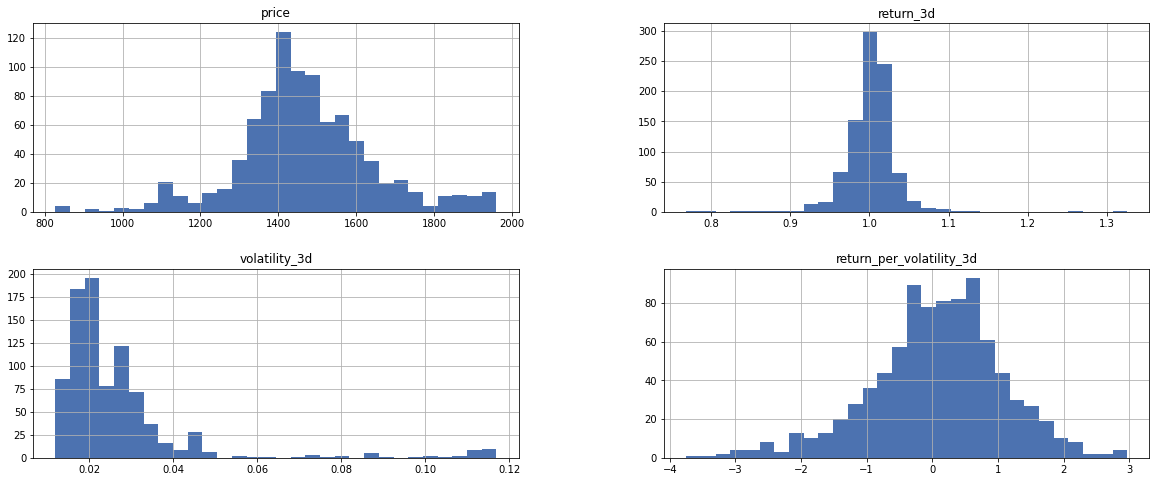

In [ ]:
df_portfolio_value_daily[['price','return_3d','volatility_3d', 'return_per_volatility_3d']].hist(bins=30, figsize=(20,8))

In [ ]:
# All days descriptive statistics
df_portfolio_value_daily.describe()

price   return_1d   return_3d  volatility_3d  volatility_30d  \
count   904.000000  903.000000  901.000000     874.000000      874.000000   
mean   1468.787182    1.000620    1.001856       0.027005        0.071449   
std     177.612770    0.018460    0.033272       0.017723        0.046890   
min     827.260593    0.826642    0.768679       0.011875        0.031417   
25%    1374.874287    0.992610    0.989172       0.017808        0.047115   
50%    1454.255312    1.001413    1.003562       0.021520        0.056936   
75%    1558.686611    1.009577    1.017056       0.028803        0.076205   
max    1960.420025    1.135925    1.325304       0.116957        0.309440   

       volatility_365d  return_per_volatility_3d  \
count       874.000000                874.000000   
mean          0.247015                  0.066446   
std           0.162109                  1.015238   
min           0.108616                 -3.750431   
25%           0.162888                 -0.497609   
50%           0.196842                  0.133688   
75%           0.263457                  0.696594   
max           1.069803                  2.968190   

       return_per_volatility_3d_rolling  
count                        845.000000  
mean                           0.064042  
std                            0.297724  
min                           -1.122156  
25%                           -0.107984  
50%                            0.082666  
75%                            0.253056  
max                            0.711258

In [ ]:
# 10% sampling - we invent not in all days, but only in 10% of days in the last 3.5 years
df_stats = df_portfolio_value_daily.sample(frac=0.1, random_state=42).describe()
df_stats

price  return_1d  return_3d  volatility_3d  volatility_30d  \
count    90.000000  90.000000  90.000000      89.000000       89.000000   
mean   1467.527622   1.000852   0.997948       0.026701        0.070645   
std     170.863568   0.020756   0.032858       0.012101        0.032015   
min    1023.991964   0.888341   0.826007       0.013387        0.035419   
25%    1373.775022   0.993089   0.986350       0.018848        0.049867   
50%    1445.881137   1.002888   1.002385       0.023910        0.063260   
75%    1554.586290   1.010668   1.013675       0.029929        0.079186   
max    1855.366245   1.049149   1.090223       0.074648        0.197501   

       volatility_365d  return_per_volatility_3d  \
count        89.000000                 89.000000   
mean          0.244235                 -0.017830   
std           0.110683                  1.013609   
min           0.122450                 -2.917995   
25%           0.172403                 -0.538190   
50%           0.218703                  0.090968   
75%           0.273763                  0.570354   
max           0.682805                  2.818151   

       return_per_volatility_3d_rolling  
count                         86.000000  
mean                           0.055802  
std                            0.274184  
min                           -0.516514  
25%                           -0.166426  
50%                            0.037758  
75%                            0.240676  
max                            0.660275

In [ ]:
# Defined previosly: SELECTED_PORTFOLIO = {'BA': 2, 'BUD': 1, 'NKE': 1, 'PTR': 1, 'SHOP': 0, 'XOM': 1, 'NVDA':2, 'CHTR':1 }

# Get all major metrics for one portfolio:
print(f'Selected portfolio: {SELECTED_PORTFOLIO}')
print(f"Mean return in 3 days = {df_stats['return_3d']['mean']-1 :.2%}")
print(f"Volatility in 3 days = {df_stats['volatility_3d']['mean'] :.1%}")
print(f"Mean return_per_volatility in 3 days = {df_stats['return_per_volatility_3d']['mean'] :.3f}")
print(f"Median return_per_volality in 3 days = {df_stats['return_per_volatility_3d']['50%'] :.3f}")
print(f"25% drawdown in 3 days = {df_stats['return_3d']['25%']-1 :.1%}")
print(f"Max drawdown in 3 days = {df_stats['return_3d']['min']-1 :.1%}")


Selected portfolio: {'BA': 2, 'BUD': 1, 'NKE': 1, 'PTR': 1, 'SHOP': 0, 'XOM': 1, 'NVDA': 2, 'CHTR': 1}
Mean return in 3 days = -0.21%
Volatility in 3 days = 2.7%
Mean return_per_volatility in 3 days = -0.018
Median return_per_volality in 3 days = 0.091
25% drawdown in 3 days = -1.4%
Max drawdown in 3 days = -17.4%


In [ ]:
# One function to get all metrics
def get_portfolio_metrics(portfolio, sample_rate, all_stock_prices):
  result = {}
  
  all_days = all_stock_prices.copy()
  # apply portfolio weigths (number of shares to buy)
  all_days['qty'] = all_days.Ticker.map(portfolio)
  all_days['price'] = all_days.qty * all_days.Close

  # get daily price of a portfolio
  portfolio_value_daily = all_days[all_days.index>='2018-01-01'].groupby('Date')['price'].sum()
  df_portfolio_value_daily = pd.DataFrame(portfolio_value_daily)

  # Generate other (daily) metrics for the portfolio
  df_portfolio_value_daily['return_1d'] = df_portfolio_value_daily.price / df_portfolio_value_daily.price.shift(1)
  df_portfolio_value_daily['return_3d'] = df_portfolio_value_daily.price / df_portfolio_value_daily.price.shift(3)

  # 30d rolling volatility annualized: https://ycharts.com/glossary/terms/rolling_vol_30
  df_portfolio_value_daily['volatility_3d'] =   df_portfolio_value_daily['return_1d'].rolling(30).std() * np.sqrt(3)
  # monthly volatility
  df_portfolio_value_daily['volatility_30d'] =   df_portfolio_value_daily['return_1d'].rolling(30).std() * np.sqrt(21)
  # yearly volatility
  df_portfolio_value_daily['volatility_365d'] =   df_portfolio_value_daily['return_1d'].rolling(30).std() * np.sqrt(251)
  
  # return per risk
  df_portfolio_value_daily['return_per_volatility_3d'] = (df_portfolio_value_daily['return_3d']-1) / df_portfolio_value_daily['volatility_3d']

  # get stats with sample rate from the params
  # we need random_state=<some number> to test all portfolios on the same sample
  df_stats = df_portfolio_value_daily.sample(frac = sample_rate, random_state=42).describe()

  result['mean_return_3d_over_one'] = df_stats['return_3d']['mean'] - 1
  result['volatility_return_3d'] = df_stats['volatility_3d']['mean']
  result['mean_return_per_vol_3d'] = df_stats['return_per_volatility_3d']['mean']
  result['median_return_per_vol_3d'] = df_stats['return_per_volatility_3d']['50%']
  result['25_percent_drawdown_3d'] = df_stats['return_3d']['25%']-1 
  result['max_drawdown_3d'] = df_stats['return_3d']['min']-1 
  
  return result

In [ ]:
res = get_portfolio_metrics(portfolio = SELECTED_PORTFOLIO,
                            sample_rate = 0.1,
                            all_stock_prices = stocks_prices[stocks_prices.Date >= '2018-01-01'][['Date','Ticker','Close']].set_index('Date')
                            )

print(res)

{'mean_return_3d_over_one': -0.0020516686309813847, 'volatility_return_3d': 0.02670120613969826, 'mean_return_per_vol_3d': -0.01782967195218224, 'median_return_per_vol_3d': 0.09096842304864716, '25_percent_drawdown_3d': -0.01364985001157859, 'max_drawdown_3d': -0.17399336228265383}


# 4) Simulate all portfolios

In [ ]:
''' Get daily price for all the portfolios '''
def simulate_all_portfolios(portfolios):
  output = pd.DataFrame()

  for current_portfolio in portfolios:
    res = get_portfolio_metrics(portfolio = current_portfolio,
                            sample_rate = 0.1,
                            all_stock_prices = stocks_prices[stocks_prices.Date >= '2018-01-01'][['Date','Ticker','Close']].set_index('Date')
                            )
    res['portfolio'] = current_portfolio
    output = output.append(res, ignore_index=True)
  return output
  

In [ ]:
simulated_result = simulate_all_portfolios(all_portfolios)

In [ ]:
simulated_result.shape

(22569, 7)

In [ ]:
# 1. Sort portfolios by mean_return_3d_over_one
simulated_result.sort_values(by='mean_return_3d_over_one', ascending=False).head(5)

25_percent_drawdown_3d  max_drawdown_3d  mean_return_3d_over_one  \
22559               -0.019746        -0.127274                 0.004532   
22552               -0.015821        -0.125061                 0.003103   
22554               -0.016829        -0.125812                 0.002975   
22555               -0.015385        -0.125174                 0.002941   
22547               -0.017367        -0.125262                 0.002862   

       mean_return_per_vol_3d  median_return_per_vol_3d  \
22559                0.156855                  0.226901   
22552                0.152703                  0.235166   
22554                0.148577                  0.282023   
22555                0.157583                  0.243272   
22547                0.124127                  0.202665   

                                                                     portfolio  \
22559  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 1, 'BUD': 0, 'XOM': 0, 'PTR': 1}   
22552  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 0, 'XOM': 3, 'PTR': 1}   
22554  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 1, 'XOM': 1, 'PTR': 2}   
22555  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 1, 'XOM': 2, 'PTR': 1}   
22547  {'SHOP': 1, 'BA': 0, 'NVDA': 0, 'NKE': 2, 'BUD': 0, 'XOM': 0, 'PTR': 2}   

       volatility_return_3d  
22559              0.042093  
22552              0.037903  
22554              0.037475  
22555              0.036855  
22547              0.037896

In [ ]:
# 2. Sort portfolios by mean_return_per_vol_3d
simulated_result.sort_values(by='mean_return_per_vol_3d', ascending=False).head(5)

25_percent_drawdown_3d  max_drawdown_3d  mean_return_3d_over_one  \
22555               -0.015385        -0.125174                 0.002941   
22559               -0.019746        -0.127274                 0.004532   
22557               -0.015915        -0.125284                 0.002804   
22552               -0.015821        -0.125061                 0.003103   
22554               -0.016829        -0.125812                 0.002975   

       mean_return_per_vol_3d  median_return_per_vol_3d  \
22555                0.157583                  0.243272   
22559                0.156855                  0.226901   
22557                0.155939                  0.202151   
22552                0.152703                  0.235166   
22554                0.148577                  0.282023   

                                                                     portfolio  \
22555  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 1, 'XOM': 2, 'PTR': 1}   
22559  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 1, 'BUD': 0, 'XOM': 0, 'PTR': 1}   
22557  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 2, 'XOM': 1, 'PTR': 1}   
22552  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 0, 'XOM': 3, 'PTR': 1}   
22554  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 1, 'XOM': 1, 'PTR': 2}   

       volatility_return_3d  
22555              0.036855  
22559              0.042093  
22557              0.036312  
22552              0.037903  
22554              0.037475

In [ ]:
# 3. Sort portfolios by median_return_per_vol_3d
simulated_result.sort_values(by='median_return_per_vol_3d', ascending=False).head(5)

25_percent_drawdown_3d  max_drawdown_3d  mean_return_3d_over_one  \
6191               -0.013737        -0.108128                -0.002003   
5935               -0.015250        -0.106858                -0.001978   
5934               -0.015443        -0.106027                -0.001994   
6172               -0.014026        -0.109101                -0.001914   
6173               -0.014760        -0.109944                -0.001896   

      mean_return_per_vol_3d  median_return_per_vol_3d  \
6191                0.037141                  0.351310   
5935                0.037171                  0.328838   
5934                0.036462                  0.326950   
6172                0.036790                  0.326930   
6173                0.037500                  0.324062   

                                                                                portfolio  \
6191  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 3, 'NKE': 1, 'BUD': 2, 'XOM': 16, 'PTR': 4}   
5935  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 3, 'NKE': 0, 'BUD': 3, 'XOM': 18, 'PTR': 4}   
5934  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 3, 'NKE': 0, 'BUD': 3, 'XOM': 17, 'PTR': 5}   
6172  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 3, 'NKE': 1, 'BUD': 1, 'XOM': 17, 'PTR': 4}   
6173  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 3, 'NKE': 1, 'BUD': 1, 'XOM': 18, 'PTR': 3}   

      volatility_return_3d  
6191              0.026280  
5935              0.026825  
5934              0.026684  
6172              0.026882  
6173              0.027048

In [ ]:
# Finding edge cases when (mostly) one stock is bought
max_count = {key: 0 for key in TICKERS}    
print(max_count)

{'PTR': 0, 'BUD': 0, 'XOM': 0, 'BA': 0, 'CHTR': 0, 'SHOP': 0, 'NVDA': 0, 'NKE': 0}


In [ ]:
# ONE STOCK PORTFOLIO 

for i,row in simulated_result.iterrows():
  for ticker in TICKERS:
    if ticker in row['portfolio'].keys() and row['portfolio'][ticker]> max_count[ticker]:
      max_count[ticker] = row['portfolio'][ticker]

print(max_count)  

{'PTR': 48, 'BUD': 31, 'XOM': 34, 'BA': 8, 'CHTR': 2, 'SHOP': 1, 'NVDA': 9, 'NKE': 11}


In [ ]:
# Get all edge cases of a portfolio with 
edge_portfolios = []
for i,row in simulated_result.iterrows():
  for ticker in row['portfolio'].keys():
    if row['portfolio'][ticker] == max_count[ticker]:
      # print(row['portfolio'])
      edge_portfolios.append(row['portfolio'])

edge_portfolios[0:10]

[{'BA': 0,
  'BUD': 0,
  'CHTR': 0,
  'NKE': 0,
  'NVDA': 0,
  'PTR': 48,
  'SHOP': 0,
  'XOM': 0},
 {'BA': 0,
  'BUD': 0,
  'CHTR': 0,
  'NKE': 0,
  'NVDA': 0,
  'PTR': 1,
  'SHOP': 0,
  'XOM': 34},
 {'BA': 0,
  'BUD': 31,
  'CHTR': 0,
  'NKE': 0,
  'NVDA': 0,
  'PTR': 2,
  'SHOP': 0,
  'XOM': 0},
 {'BA': 0,
  'BUD': 0,
  'CHTR': 0,
  'NKE': 11,
  'NVDA': 0,
  'PTR': 2,
  'SHOP': 0,
  'XOM': 0},
 {'BA': 0,
  'BUD': 0,
  'CHTR': 0,
  'NKE': 11,
  'NVDA': 0,
  'PTR': 1,
  'SHOP': 0,
  'XOM': 1},
 {'BA': 0,
  'BUD': 1,
  'CHTR': 0,
  'NKE': 11,
  'NVDA': 0,
  'PTR': 1,
  'SHOP': 0,
  'XOM': 1},
 {'BA': 0,
  'BUD': 0,
  'CHTR': 0,
  'NKE': 0,
  'NVDA': 9,
  'PTR': 4,
  'SHOP': 0,
  'XOM': 0},
 {'BA': 0,
  'BUD': 0,
  'CHTR': 0,
  'NKE': 0,
  'NVDA': 9,
  'PTR': 2,
  'SHOP': 0,
  'XOM': 1},
 {'BA': 0,
  'BUD': 0,
  'CHTR': 0,
  'NKE': 0,
  'NVDA': 9,
  'PTR': 1,
  'SHOP': 0,
  'XOM': 2},
 {'BA': 0,
  'BUD': 1,
  'CHTR': 0,
  'NKE': 0,
  'NVDA': 9,
  'PTR': 2,
  'SHOP': 0,
  'XOM': 0}]

In [ ]:
top_portfolios = edge_portfolios.copy()

top_portfolios.append(simulated_result.sort_values(by='mean_return_3d_over_one', ascending=False).head(1)['portfolio'].values[0])
top_portfolios.append(simulated_result.sort_values(by='median_return_per_vol_3d', ascending=False).head(1)['portfolio'].values[0])

In [ ]:
top_portfolios[0:10]

[{'BA': 0,
  'BUD': 0,
  'CHTR': 0,
  'NKE': 0,
  'NVDA': 0,
  'PTR': 48,
  'SHOP': 0,
  'XOM': 0},
 {'BA': 0,
  'BUD': 0,
  'CHTR': 0,
  'NKE': 0,
  'NVDA': 0,
  'PTR': 1,
  'SHOP': 0,
  'XOM': 34},
 {'BA': 0,
  'BUD': 31,
  'CHTR': 0,
  'NKE': 0,
  'NVDA': 0,
  'PTR': 2,
  'SHOP': 0,
  'XOM': 0},
 {'BA': 0,
  'BUD': 0,
  'CHTR': 0,
  'NKE': 11,
  'NVDA': 0,
  'PTR': 2,
  'SHOP': 0,
  'XOM': 0},
 {'BA': 0,
  'BUD': 0,
  'CHTR': 0,
  'NKE': 11,
  'NVDA': 0,
  'PTR': 1,
  'SHOP': 0,
  'XOM': 1},
 {'BA': 0,
  'BUD': 1,
  'CHTR': 0,
  'NKE': 11,
  'NVDA': 0,
  'PTR': 1,
  'SHOP': 0,
  'XOM': 1},
 {'BA': 0,
  'BUD': 0,
  'CHTR': 0,
  'NKE': 0,
  'NVDA': 9,
  'PTR': 4,
  'SHOP': 0,
  'XOM': 0},
 {'BA': 0,
  'BUD': 0,
  'CHTR': 0,
  'NKE': 0,
  'NVDA': 9,
  'PTR': 2,
  'SHOP': 0,
  'XOM': 1},
 {'BA': 0,
  'BUD': 0,
  'CHTR': 0,
  'NKE': 0,
  'NVDA': 9,
  'PTR': 1,
  'SHOP': 0,
  'XOM': 2},
 {'BA': 0,
  'BUD': 1,
  'CHTR': 0,
  'NKE': 0,
  'NVDA': 9,
  'PTR': 2,
  'SHOP': 0,
  'XOM': 0}]

In [ ]:
# filter_edge = simulated_result.portfolio.isin(top_portfolios)
# simulated_result[filter_edge]

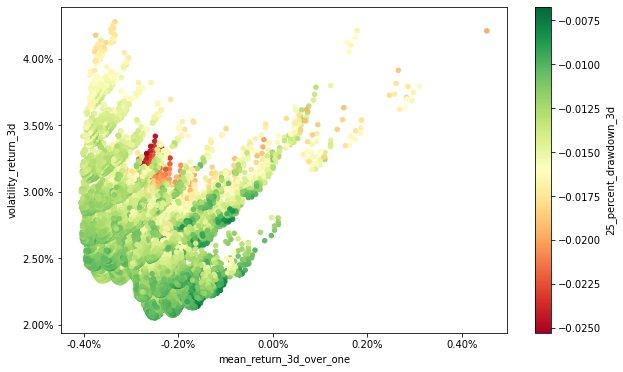

In [ ]:
# https://stackoverflow.com/questions/31357611/format-y-axis-as-percent
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax = simulated_result.plot.scatter(x = 'mean_return_3d_over_one', 
                                   y = 'volatility_return_3d', 
                                   c = '25_percent_drawdown_3d', 
                                   colormap='RdYlGn', 
                                   ax=ax,
                                   figsize=(10,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))


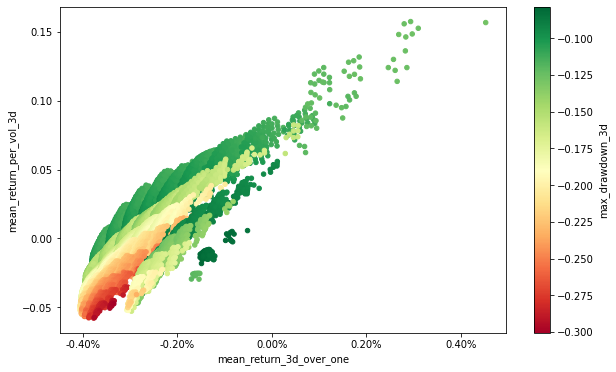

In [ ]:
fig, ax = plt.subplots()
# mean_return_3d_over_one
# median_return_per_vol_3d
# '25_percent_drawdown_3d'
ax = simulated_result.plot.scatter(x = 'mean_return_3d_over_one', 
                                   y = 'mean_return_per_vol_3d', 
                                   c = 'max_drawdown_3d', 
                                   colormap='RdYlGn', 
                                   ax=ax,
                                   figsize=(10,6))
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))


In [ ]:
# Adjusting point sizes according to the returns
max_return = simulated_result.mean_return_3d_over_one.max()
min_return = simulated_result.mean_return_3d_over_one.min()
range = max_return - min_return

min_size = 1
max_size = 25

simulated_result['size'] = min_size + (max_size-min_size)*(simulated_result.mean_return_3d_over_one -  min_return)/range
simulated_result['top_20_percent_portfolios'] = simulated_result.mean_return_3d_over_one >= min_return + 0.8*range

In [ ]:
simulated_result[simulated_result['top_20_percent_portfolios'] == True].shape

(7, 9)

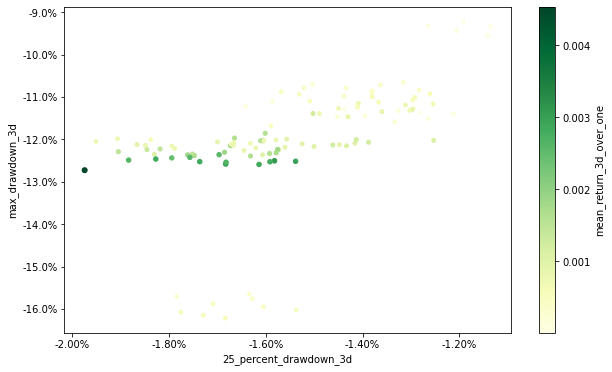

In [ ]:
filter1 = simulated_result.mean_return_3d_over_one>0

fig, ax = plt.subplots()

ax = simulated_result[filter1].plot.scatter(x = '25_percent_drawdown_3d', 
                                   y = 'max_drawdown_3d', 
                                  #  alpha = 0.7,
                                   s = 'size',
                                   c = 'mean_return_3d_over_one', 
                                   colormap='YlGn',
                                  #  colormap='Greens', 
                                   ax=ax,
                                   figsize=(10,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [ ]:
simulated_result['portfolio_str'] = simulated_result['portfolio'].apply(lambda x: str(x))

In [ ]:
simulated_result.head(5)

25_percent_drawdown_3d  max_drawdown_3d  mean_return_3d_over_one  \
0               -0.024473        -0.082574                -0.002491   
1               -0.023884        -0.083338                -0.002504   
2               -0.023298        -0.084095                -0.002517   
3               -0.022678        -0.084893                -0.002528   
4               -0.022124        -0.085650                -0.002538   

   mean_return_per_vol_3d  median_return_per_vol_3d  \
0               -0.018934                 -0.137084   
1               -0.018246                 -0.139251   
2               -0.017566                 -0.147530   
3               -0.016856                 -0.156349   
4               -0.016194                 -0.164793   

                                                                             portfolio  \
0  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 0, 'PTR': 48}   
1  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 1, 'PTR': 46}   
2  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 2, 'PTR': 45}   
3  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 3, 'PTR': 43}   
4  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 4, 'PTR': 42}   

   volatility_return_3d      size  top_20_percent_portfolios  \
0              0.034166  5.393795                      False   
1              0.033789  5.356168                      False   
2              0.033430  5.322382                      False   
3              0.033068  5.290431                      False   
4              0.032741  5.263526                      False   

                                                                         portfolio_str  
0  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 0, 'PTR': 48}  
1  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 1, 'PTR': 46}  
2  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 2, 'PTR': 45}  
3  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 3, 'PTR': 43}  
4  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 4, 'PTR': 42}

In [ ]:
fig = px.scatter(simulated_result,
                 x = '25_percent_drawdown_3d', 
                 y= 'max_drawdown_3d', #'Initial_Price',
                #  color = 'mean_return_per_vol_3d',
                 color = 'mean_return_3d_over_one',
                 color_continuous_scale=["red", "yellow", "green"],
                 color_continuous_midpoint=0,
                 title = '25_percent_drawdown vs. max_drawdown_3d',
                 opacity =0.7,
                 size= 'size',
                 width=1000,
                 height=800,
                 hover_data=['portfolio_str','mean_return_per_vol_3d','mean_return_3d_over_one'])
fig.show()

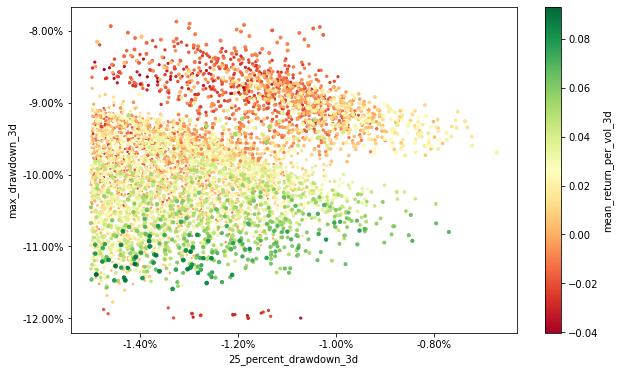

In [ ]:
# Going closer to some area
filter1 = simulated_result.max_drawdown_3d>-0.12
filter2 = simulated_result['25_percent_drawdown_3d'] >-0.015

fig, ax = plt.subplots()

ax = simulated_result[filter1 & filter2].plot.scatter(x = '25_percent_drawdown_3d', 
                                   y = 'max_drawdown_3d', 
                                  #  alpha = 0.7,
                                   s = 'size',
                                   c = 'mean_return_per_vol_3d', 
                                   colormap='RdYlGn',
                                  #  colormap='Greens', 
                                   ax=ax,
                                   figsize=(10,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [ ]:
simulated_result.sort_values(by='mean_return_3d_over_one', ascending=False).head(1).portfolio
# pd.Series(simulated_result.sort_values(by='mean_return_3d_over_one', ascending=False).head(1).portfolio).plot.barh();


22559    {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 1, 'BUD': 0, 'XOM': 0, 'PTR': 1}
Name: portfolio, dtype: object

In [ ]:
# Get agg stats for the normalisation

simulated_result_stats = simulated_result.describe().transpose()
simulated_result_stats

count      mean       std       min       25%  \
25_percent_drawdown_3d    22569.0 -0.013633  0.002339 -0.025289 -0.014910   
max_drawdown_3d           22569.0 -0.138409  0.044437 -0.300640 -0.166920   
mean_return_3d_over_one   22569.0 -0.002926  0.000739 -0.004065 -0.003466   
mean_return_per_vol_3d    22569.0 -0.002819  0.023973 -0.057937 -0.018442   
median_return_per_vol_3d  22569.0  0.074873  0.083582 -0.177634  0.013660   
volatility_return_3d      22569.0  0.027104  0.003000  0.020495  0.025204   
size                      22569.0  4.178372  2.062345  1.000000  2.671982   

                               50%       75%        max  
25_percent_drawdown_3d   -0.013310 -0.011959  -0.006721  
max_drawdown_3d          -0.130920 -0.099863  -0.078499  
mean_return_3d_over_one  -0.003060 -0.002547   0.004532  
mean_return_per_vol_3d   -0.005638  0.010845   0.157583  
median_return_per_vol_3d  0.075782  0.135190   0.351310  
volatility_return_3d      0.026713  0.028614   0.042789  
size                      3.805339  5.236334  25.000000

## 4.1) Rescale values, score the portfolios, and rank them

In [ ]:
NUMERIC_COLUMNS = ['25_percent_drawdown_3d','max_drawdown_3d','mean_return_3d_over_one','mean_return_per_vol_3d','median_return_per_vol_3d']
WEIGHTS = {'25_percent_drawdown_3d' : 1, 
           'max_drawdown_3d' : 1, 
           'mean_return_3d_over_one' : 1,
           'mean_return_per_vol_3d' : 1,
           'median_return_per_vol_3d' : 1}

In [ ]:
#  Define norm() function : transpose every column to z_new = (z-mean(z))/std(z)
def norm(x):
  return (x-simulated_result_stats['mean'])/ simulated_result_stats['std']

simulated_result_numerical = simulated_result.copy()[NUMERIC_COLUMNS]

simulated_result_numerical_norm = norm(simulated_result_numerical)
simulated_result_numerical_norm 

25_percent_drawdown_3d  max_drawdown_3d  mean_return_3d_over_one  \
0                   -4.634527         1.256494                 0.589341   
1                   -4.382588         1.239298                 0.571096   
2                   -4.132145         1.222272                 0.554713   
3                   -3.866994         1.204320                 0.539221   
4                   -3.630290         1.187277                 0.526175   
...                       ...              ...                      ...   
22564               -1.478271        -0.458579                 4.582212   
22565               -1.033900        -0.474509                 4.583800   
22566               -0.743340        -0.490151                 4.589069   
22567               -1.130749        -0.431430                 4.471657   
22568               -1.157824        -0.405257                 4.372982   

       mean_return_per_vol_3d  median_return_per_vol_3d  size  \
0                   -0.672215                 -2.535914   NaN   
1                   -0.643515                 -2.561835   NaN   
2                   -0.615160                 -2.660888   NaN   
3                   -0.585557                 -2.766401   NaN   
4                   -0.557918                 -2.867422   NaN   
...                       ...                       ...   ...   
22564                3.173173                  0.524433   NaN   
22565                3.374652                  1.161134   NaN   
22566                3.555792                  1.277010   NaN   
22567                3.273169                  0.965774   NaN   
22568                3.172938                  1.226737   NaN   

       volatility_return_3d  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
...                     ...  
22564                   NaN  
22565                   NaN  
22566                   NaN  
22567                   NaN  
22568                   NaN  

[22569 rows x 7 columns]

In [ ]:
# Values before
simulated_result_numerical

25_percent_drawdown_3d  max_drawdown_3d  mean_return_3d_over_one  \
0                   -0.024473        -0.082574                -0.002491   
1                   -0.023884        -0.083338                -0.002504   
2                   -0.023298        -0.084095                -0.002517   
3                   -0.022678        -0.084893                -0.002528   
4                   -0.022124        -0.085650                -0.002538   
...                       ...              ...                      ...   
22564               -0.017091        -0.158787                 0.000459   
22565               -0.016052        -0.159495                 0.000460   
22566               -0.015372        -0.160190                 0.000464   
22567               -0.016278        -0.157580                 0.000377   
22568               -0.016341        -0.156417                 0.000304   

       mean_return_per_vol_3d  median_return_per_vol_3d  
0                   -0.018934                 -0.137084  
1                   -0.018246                 -0.139251  
2                   -0.017566                 -0.147530  
3                   -0.016856                 -0.156349  
4                   -0.016194                 -0.164793  
...                       ...                       ...  
22564                0.073251                  0.118707  
22565                0.078081                  0.171924  
22566                0.082423                  0.181609  
22567                0.075648                  0.155595  
22568                0.073245                  0.177407  

[22569 rows x 5 columns]

In [ ]:
simulated_result.head()

25_percent_drawdown_3d  max_drawdown_3d  mean_return_3d_over_one  \
0               -0.024473        -0.082574                -0.002491   
1               -0.023884        -0.083338                -0.002504   
2               -0.023298        -0.084095                -0.002517   
3               -0.022678        -0.084893                -0.002528   
4               -0.022124        -0.085650                -0.002538   

   mean_return_per_vol_3d  median_return_per_vol_3d  \
0               -0.018934                 -0.137084   
1               -0.018246                 -0.139251   
2               -0.017566                 -0.147530   
3               -0.016856                 -0.156349   
4               -0.016194                 -0.164793   

                                                                             portfolio  \
0  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 0, 'PTR': 48}   
1  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 1, 'PTR': 46}   
2  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 2, 'PTR': 45}   
3  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 3, 'PTR': 43}   
4  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 4, 'PTR': 42}   

   volatility_return_3d      size  top_20_percent_portfolios  \
0              0.034166  5.393795                      False   
1              0.033789  5.356168                      False   
2              0.033430  5.322382                      False   
3              0.033068  5.290431                      False   
4              0.032741  5.263526                      False   

                                                                         portfolio_str  
0  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 0, 'PTR': 48}  
1  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 1, 'PTR': 46}  
2  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 2, 'PTR': 45}  
3  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 3, 'PTR': 43}  
4  {'SHOP': 0, 'CHTR': 0, 'BA': 0, 'NVDA': 0, 'NKE': 0, 'BUD': 0, 'XOM': 4, 'PTR': 42}

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f91ea8ac950>,
      dtype=object)

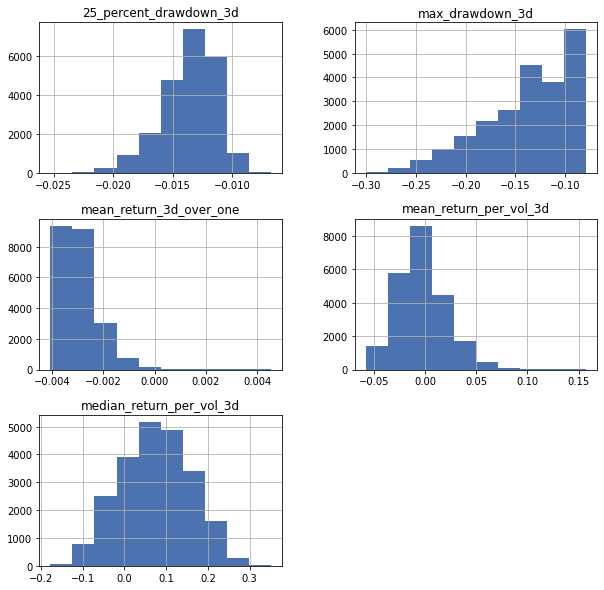

In [ ]:
simulated_result_numerical.hist(figsize=(10,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f91e9a4afd0>,
      dtype=object)

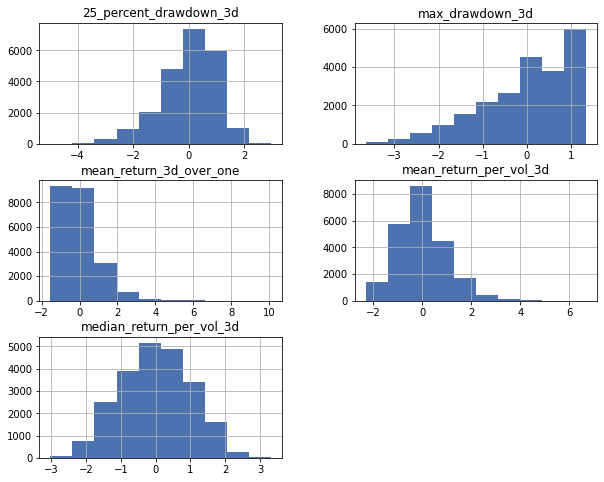

In [ ]:
# shape is the same, but min-max values are now close to N(0,1) - std. normal distribution 
simulated_result_numerical_norm[NUMERIC_COLUMNS].hist(figsize=(10,8))

In [ ]:
simulated_result_numerical_norm[NUMERIC_COLUMNS]

25_percent_drawdown_3d  max_drawdown_3d  mean_return_3d_over_one  \
0                   -4.634527         1.256494                 0.589341   
1                   -4.382588         1.239298                 0.571096   
2                   -4.132145         1.222272                 0.554713   
3                   -3.866994         1.204320                 0.539221   
4                   -3.630290         1.187277                 0.526175   
...                       ...              ...                      ...   
22564               -1.478271        -0.458579                 4.582212   
22565               -1.033900        -0.474509                 4.583800   
22566               -0.743340        -0.490151                 4.589069   
22567               -1.130749        -0.431430                 4.471657   
22568               -1.157824        -0.405257                 4.372982   

       mean_return_per_vol_3d  median_return_per_vol_3d  
0                   -0.672215                 -2.535914  
1                   -0.643515                 -2.561835  
2                   -0.615160                 -2.660888  
3                   -0.585557                 -2.766401  
4                   -0.557918                 -2.867422  
...                       ...                       ...  
22564                3.173173                  0.524433  
22565                3.374652                  1.161134  
22566                3.555792                  1.277010  
22567                3.273169                  0.965774  
22568                3.172938                  1.226737  

[22569 rows x 5 columns]

In [ ]:
# Define a row level function that calculates score
def get_score(row, debug = False):
  # print(f' INPUT ROW = {row}') 
  rez = 0
  for column_name in WEIGHTS.keys():
      rez += row[column_name] * WEIGHTS[column_name]
      # if debug == True:
        # print(f'column_name ={column_name}, weight = {WEIGHTS[column_name]}, value = {row[column_name]}')
  # print(f'rez = {rez}')      
  return rez

In [ ]:
simulated_result_numerical_norm['score'] = simulated_result_numerical_norm.apply(lambda row: get_score(row), axis=1)
# simulated_result_numerical_norm.apply(lambda row: row*WEIGHTS)

In [ ]:
simulated_result_numerical_norm.sort_values(by='score', ascending=False)

25_percent_drawdown_3d  max_drawdown_3d  mean_return_3d_over_one  \
22559               -2.613572         0.250582                10.096094   
22555               -0.748781         0.297827                 7.942967   
22552               -0.935294         0.300390                 8.162276   
22554               -1.366436         0.283479                 7.989159   
22557               -0.975399         0.295352                 7.757815   
...                       ...              ...                      ...   
19844               -1.539955        -3.228292                -1.134576   
19854               -1.527335        -3.398308                -1.116571   
19855               -1.648472        -3.393579                -1.092979   
19856               -1.839787        -3.360113                -1.147844   
19857               -2.141793        -3.538534                -1.121729   

       mean_return_per_vol_3d  median_return_per_vol_3d  size  \
22559                6.660651                  1.818901   NaN   
22555                6.691004                  2.014760   NaN   
22552                6.487471                  1.917776   NaN   
22554                6.315332                  2.478392   NaN   
22557                6.622445                  1.522783   NaN   
...                       ...                       ...   ...   
19844               -2.230769                 -2.466415   NaN   
19854               -2.247788                 -2.379587   NaN   
19855               -2.228727                 -2.309752   NaN   
19856               -2.299180                 -2.467932   NaN   
19857               -2.284551                 -2.175532   NaN   

       volatility_return_3d      score  
22559                   NaN  16.212655  
22555                   NaN  16.197777  
22552                   NaN  15.932619  
22554                   NaN  15.699927  
22557                   NaN  15.222996  
...                     ...        ...  
19844                   NaN -10.600008  
19854                   NaN -10.669588  
19855                   NaN -10.673510  
19856                   NaN -11.114856  
19857                   NaN -11.262138  

[22569 rows x 8 columns]

In [ ]:
FULL_COLUMNS = NUMERIC_COLUMNS.copy()
FULL_COLUMNS.append('score')
FULL_COLUMNS

['25_percent_drawdown_3d',
 'max_drawdown_3d',
 'mean_return_3d_over_one',
 'mean_return_per_vol_3d',
 'median_return_per_vol_3d',
 'score']

In [ ]:
scored_simulated_result = simulated_result.join(simulated_result_numerical_norm[FULL_COLUMNS], rsuffix='_normalized')
scored_simulated_result.sort_values(by='score', ascending=False).head(5)

25_percent_drawdown_3d  max_drawdown_3d  mean_return_3d_over_one  \
22559               -0.019746        -0.127274                 0.004532   
22555               -0.015385        -0.125174                 0.002941   
22552               -0.015821        -0.125061                 0.003103   
22554               -0.016829        -0.125812                 0.002975   
22557               -0.015915        -0.125284                 0.002804   

       mean_return_per_vol_3d  median_return_per_vol_3d  \
22559                0.156855                  0.226901   
22555                0.157583                  0.243272   
22552                0.152703                  0.235166   
22554                0.148577                  0.282023   
22557                0.155939                  0.202151   

                                                                     portfolio  \
22559  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 1, 'BUD': 0, 'XOM': 0, 'PTR': 1}   
22555  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 1, 'XOM': 2, 'PTR': 1}   
22552  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 0, 'XOM': 3, 'PTR': 1}   
22554  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 1, 'XOM': 1, 'PTR': 2}   
22557  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 2, 'XOM': 1, 'PTR': 1}   

       volatility_return_3d       size  top_20_percent_portfolios  \
22559              0.042093  25.000000                       True   
22555              0.036855  20.559510                       True   
22552              0.037903  21.011801                       True   
22554              0.037475  20.654774                       True   
22557              0.036312  20.177661                      False   

                                                                 portfolio_str  \
22559  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 1, 'BUD': 0, 'XOM': 0, 'PTR': 1}   
22555  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 1, 'XOM': 2, 'PTR': 1}   
22552  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 0, 'XOM': 3, 'PTR': 1}   
22554  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 1, 'XOM': 1, 'PTR': 2}   
22557  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 2, 'XOM': 1, 'PTR': 1}   

       25_percent_drawdown_3d_normalized  max_drawdown_3d_normalized  \
22559                          -2.613572                    0.250582   
22555                          -0.748781                    0.297827   
22552                          -0.935294                    0.300390   
22554                          -1.366436                    0.283479   
22557                          -0.975399                    0.295352   

       mean_return_3d_over_one_normalized  mean_return_per_vol_3d_normalized  \
22559                           10.096094                           6.660651   
22555                            7.942967                           6.691004   
22552                            8.162276                           6.487471   
22554                            7.989159                           6.315332   
22557                            7.757815                           6.622445   

       median_return_per_vol_3d_normalized      score  
22559                             1.818901  16.212655  
22555                             2.014760  16.197777  
22552                             1.917776  15.932619  
22554                             2.478392  15.699927  
22557                             1.522783  15.222996

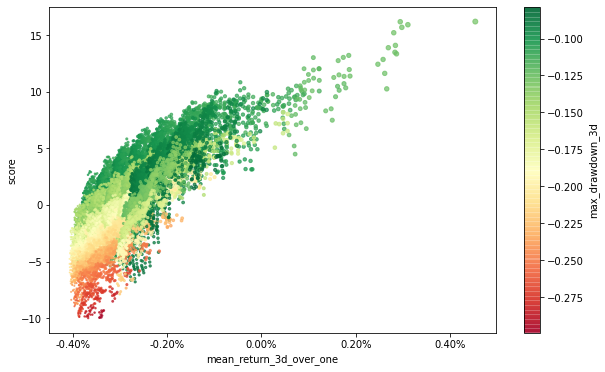

In [ ]:
fig, ax = plt.subplots()

ax = scored_simulated_result[scored_simulated_result.score>-10].plot.scatter(x = 'mean_return_3d_over_one', 
                                   y = 'score', 
                                   alpha = 0.7,
                                   s = 'size',
                                   c = 'max_drawdown_3d', 
                                   colormap='RdYlGn',
                                  #  colormap='Greens', 
                                   ax=ax,
                                   figsize=(10,6))
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [ ]:
# Top-top results for scores

fig2 = px.scatter(scored_simulated_result[scored_simulated_result.score>8],
                 x = 'mean_return_3d_over_one', 
                 y= 'score', #'Initial_Price',
                #  color = 'mean_return_per_vol_3d',
                 color = 'max_drawdown_3d',
                 color_continuous_scale=["red", "yellow", "green"],
                 color_continuous_midpoint=0,
                 title = 'Top SCORE portfolios',
                 opacity =0.7,
                 size= 'score',
                 width=1000,
                 height=800,
                 hover_data=['portfolio_str','mean_return_per_vol_3d','median_return_per_vol_3d','mean_return_3d_over_one', 'max_drawdown_3d', '25_percent_drawdown_3d'])
fig2.show()

In [ ]:
# This will create a permanent link with a dynamic graph to embed to the website

# import chart_studio.plotly as py

# py.plot(fig2, filename = 'part8_fig2_all_portfolios_scores', auto_open=True)

# Output link: https://plotly.com/~realmistic/3/
# You can embed that as iframe to your website (and customise)
# https://plotly.com/chart-studio-help/embed-graphs-in-websites/#step-8-customize-the-iframe

'https://plotly.com/~realmistic/3/'

In [ ]:
scored_simulated_result.sort_values(by='score', ascending=False).head(5)

25_percent_drawdown_3d  max_drawdown_3d  mean_return_3d_over_one  \
22559               -0.019746        -0.127274                 0.004532   
22555               -0.015385        -0.125174                 0.002941   
22552               -0.015821        -0.125061                 0.003103   
22554               -0.016829        -0.125812                 0.002975   
22557               -0.015915        -0.125284                 0.002804   

       mean_return_per_vol_3d  median_return_per_vol_3d  \
22559                0.156855                  0.226901   
22555                0.157583                  0.243272   
22552                0.152703                  0.235166   
22554                0.148577                  0.282023   
22557                0.155939                  0.202151   

                                                                     portfolio  \
22559  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 1, 'BUD': 0, 'XOM': 0, 'PTR': 1}   
22555  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 1, 'XOM': 2, 'PTR': 1}   
22552  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 0, 'XOM': 3, 'PTR': 1}   
22554  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 1, 'XOM': 1, 'PTR': 2}   
22557  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 2, 'XOM': 1, 'PTR': 1}   

       volatility_return_3d       size  top_20_percent_portfolios  \
22559              0.042093  25.000000                       True   
22555              0.036855  20.559510                       True   
22552              0.037903  21.011801                       True   
22554              0.037475  20.654774                       True   
22557              0.036312  20.177661                      False   

                                                                 portfolio_str  \
22559  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 1, 'BUD': 0, 'XOM': 0, 'PTR': 1}   
22555  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 1, 'XOM': 2, 'PTR': 1}   
22552  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 0, 'XOM': 3, 'PTR': 1}   
22554  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 1, 'XOM': 1, 'PTR': 2}   
22557  {'SHOP': 1, 'BA': 0, 'NVDA': 1, 'NKE': 0, 'BUD': 2, 'XOM': 1, 'PTR': 1}   

       25_percent_drawdown_3d_normalized  max_drawdown_3d_normalized  \
22559                          -2.613572                    0.250582   
22555                          -0.748781                    0.297827   
22552                          -0.935294                    0.300390   
22554                          -1.366436                    0.283479   
22557                          -0.975399                    0.295352   

       mean_return_3d_over_one_normalized  mean_return_per_vol_3d_normalized  \
22559                           10.096094                           6.660651   
22555                            7.942967                           6.691004   
22552                            8.162276                           6.487471   
22554                            7.989159                           6.315332   
22557                            7.757815                           6.622445   

       median_return_per_vol_3d_normalized      score  
22559                             1.818901  16.212655  
22555                             2.014760  16.197777  
22552                             1.917776  15.932619  
22554                             2.478392  15.699927  
22557                             1.522783  15.222996